In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from datetime import datetime

In [2]:
#Collision_json ='https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.geojson'
#Collision_gdf = gpd.read_file(Collision_json)

In [3]:
#StreetSigns = gpd.read_file('https://opendata.arcgis.com/datasets/411a96b39c834a2380a256b8afa5003b_0.geojson')

In [4]:
#StreetSigns.to_file("StreetSigns.gpkg", layer='StreetSigns', driver="GPKG")

In [4]:
Bike_Collision_json ='/home/jovyan/CTEPaper/Bike_Collision.geojson'
Bike_Collision = gpd.read_file(Bike_Collision_json)

In [5]:
SeattleStreets_json ='/home/jovyan/CTEPaper/Seattle_Streets.geojson'
SeattleStreets = gpd.read_file(SeattleStreets_json)

In [6]:
SeattleStreets.columns

Index(['OBJECTID', 'ARTCLASS', 'COMPKEY', 'UNITID', 'UNITID2', 'UNITIDSORT',
       'UNITDESC', 'STNAME_ORD', 'XSTRLO', 'XSTRHI', 'ARTDESCRIPT', 'OWNER',
       'STATUS', 'BLOCKNBR', 'SPEEDLIMIT', 'SEGDIR', 'ONEWAY', 'ONEWAYDIR',
       'FLOW', 'SEGLENGTH', 'SURFACEWIDTH', 'SURFACETYPE_1', 'SURFACETYPE_2',
       'INTRLO', 'DIRLO', 'INTKEYLO', 'INTRHI', 'DIRHI', 'NATIONHWYSYS',
       'STREETTYPE', 'PVMTCONDINDX1', 'PVMTCONDINDX2', 'TRANCLASS',
       'TRANDESCRIPT', 'SLOPE_PCT', 'PVMTCATEGORY', 'PARKBOULEVARD',
       'SHAPE_Length', 'geometry'],
      dtype='object')

In [8]:
#Bike_Collision = Collision_gdf[Collision_gdf['PEDCYLCOUNT']>=1]
#Bike_Collision.to_file("Bike_Collision.geojson", driver='GeoJSON')
Collisions = Bike_Collision[['OBJECTID','LOCATION','ADDRTYPE','SEVERITYCODE','LOCATION','PEDCYLCOUNT','INCDATE','INCDTTM','UNDERINFL','WEATHER','LIGHTCOND','SPEEDING','geometry']]

In [8]:
#Collisions.to_file("Collisions.geojson", driver='GeoJSON')

In [9]:
Collisions['INCDTTM']=pd.to_datetime(Collisions['INCDTTM'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
Collisions = Collisions.set_index('INCDTTM')

In [12]:
A = Collisions.loc[(Collisions.index.year<=2019) & (Collisions.index.year>=2012)]

In [19]:
type(A)

geopandas.geodataframe.GeoDataFrame

In [13]:
NoIntersectionA = A[A.ADDRTYPE == 'Block']

In [21]:
type(NoIntersectionA)

geopandas.geodataframe.GeoDataFrame

In [14]:
NoIntersectionA.to_file("NoIntersectionA.geojson", driver="GeoJSON")

In [15]:
NoIntersectionA.SEVERITYCODE.value_counts()

2     1093
1      163
2b      88
3        5
Name: SEVERITYCODE, dtype: int64

In [ ]:
#NoIntersectionA.to_file("BCollisions1219.gpkg", layer='Bike_Collisions', driver="GPKG")

In [ ]:
#Bike_Collision.loc[Bike_Collision.index.year==2004].shape

In [16]:
Streets = SeattleStreets[['OBJECTID','ARTCLASS','STNAME_ORD','SPEEDLIMIT', 'ONEWAY','SLOPE_PCT','SHAPE_Length','geometry']]

In [17]:
Streets.to_file("Streets.geojson", driver="GeoJSON")

In [ ]:
#Streets.to_file("Streets.gpkg", layer='Seattle_Streeets', driver="GPKG")

In [ ]:
#f, ax = plt.subplots(figsize=(30,30))
#Collisions.plot(ax=ax,color ="red", markersize=1, legend=True)
#Streets.plot(ax=ax)

In [ ]:
#Collisions_clean = Collisions[Collisions.geometry.type == 'Point']
#NewCollisions = gpd.sjoin(Collisions_clean, Streets,how='inner',op='intersects')
#NoIntersectionCollision = Collisions_clean[Collisions_clean.ADDRTYPE != 'Intersection']

Copy Snapping here

In [18]:
NoIntersectionA=NoIntersectionA.drop(NoIntersectionA.index[[127,687,695,767,819,837]])

In [145]:
#NoIntersectionA = NoIntersectionA.drop(NoIntersectionA.index[687])

In [19]:
offset=0.0002
bbox=NoIntersectionA.bounds+[-offset, -offset,offset,offset]

In [21]:
hits = bbox.apply(lambda row: list(Streets.sindex.intersection(row)), axis=1)

This gives us a new, longer DataFrame that has one row for every element in the list of line indexes we got back from the spatial index.
It implicitly drops those that didn’t have any lines within their window.

In [22]:
tmp = pd.DataFrame({
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
})

In [23]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(Streets.reset_index(drop=True), on="line_i")
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(NoIntersectionA.geometry.rename("point"), on='pt_idx')
# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=NoIntersectionA.crs)
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

In [24]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= 0.001]
# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()
# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

In [25]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))
# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

In [26]:
#Identify the columns we want to copy from the closest line to the point, such as a line ID.

# Create a new GeoDataFrame from the columns from the closest line and new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest,geometry=new_pts)

In [27]:
# Join back to the original points:
updated_points = NoIntersectionA.drop(columns=["geometry"]).join(snapped,on=None, how='left', lsuffix='_intersection', rsuffix='_snapped', sort=False)


In [28]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

Road Classification a b c 
Speed Limit 60 25 30
Warnning-Speed sign 0 1

Weather a b c
Lighting a b c
Slop of streets 1 2 3
block length(?)

In [29]:
Collision_Streets = updated_points.drop('point',1)

In [30]:
Collision_Streets.to_file("Collision_Streets.shp")

#### The frequency of outcome variable'SEVERITYCODE'
•3—fatality
• 2b—serious injury
• 2—injury
• 1—prop damage
• 0—unknown

In [31]:
Collision_Streets.SEVERITYCODE.value_counts()

2     1088
1      163
2b      87
3        5
Name: SEVERITYCODE, dtype: int64

#### The frequency of independent variable'Speed limit'

In [32]:
Collision_Streets.SPEEDLIMIT.value_counts()

25.0    753
30.0    302
20.0    192
35.0     72
40.0     11
0.0      10
45.0      3
Name: SPEEDLIMIT, dtype: int64

In [42]:
Collision_Streets.reset_index(drop=True, inplace=True) 

In [44]:
Collision_Streets.to_file("Collision_Streets.shp")

### Response variable:
'SEVERITYCODE' 

### Independent variable:
'ARTCLASS';
'SPEEDLIMIT';
'SLOPE_PCT';
'WEATHER';
'LIGHTCOND'
'ONEWAY'

In [34]:
Collision_Streets[['SEVERITYCODE','WEATHER','LIGHTCOND','ARTCLASS','SPEEDLIMIT','ONEWAY','SLOPE_PCT']].iloc[0:30]

,SEVERITYCODE,WEATHER,LIGHTCOND,ARTCLASS,SPEEDLIMIT,ONEWAY,SLOPE_PCT
2012-01-13 01:42:00,2,Clear or Partly Cloudy,Dark - Street Lights On,1.0,25.0,N,15.0
2012-02-02 11:57:00,2,Overcast,Daylight,3.0,30.0,N,4.0
2012-02-16 09:32:00,2,Raining,Daylight,2.0,30.0,N,5.0
2012-02-17 17:59:00,2,Raining,Dark - Street Lights On,2.0,25.0,N,3.0
2012-02-23 15:28:00,2b,Overcast,Daylight,2.0,30.0,N,3.0
2012-02-28 12:40:00,2,Clear or Partly Cloudy,Daylight,2.0,25.0,N,2.0
2012-03-08 08:20:00,2,Overcast,Daylight,0.0,20.0,N,6.0
2012-03-08 17:12:00,2,Clear or Partly Cloudy,Daylight,1.0,25.0,Y,0.0
2012-03-08 21:15:00,2,Clear or Partly Cloudy,Dark - Street Lights On,2.0,25.0,N,1.0
2012-03-19 14:18:00,2,Clear or Partly Cloudy,Daylight,1.0,35.0,N,1.0


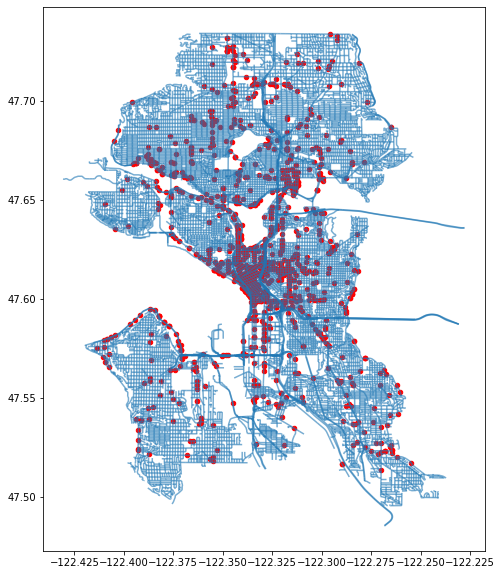

In [35]:
f, ax = plt.subplots(figsize=(10,10))
Streets.plot(ax=ax, alpha=0.6)
Collision_Streets.plot(ax=ax,color ="red", markersize=20, legend=True);

In [45]:
Collision_Streets.head()

,OBJECTID_intersection,LOCATION,ADDRTYPE,SEVERITYCODE,LOCATION,PEDCYLCOUNT,INCDATE,UNDERINFL,WEATHER,LIGHTCOND,...,line_i,OBJECTID_snapped,ARTCLASS,STNAME_ORD,SPEEDLIMIT,ONEWAY,SLOPE_PCT,SHAPE_Length,geometry,snap_dist
0,119070,E DENNY WAY BETWEEN MELROSE AVE AND BELLEVUE AVE,Block,2,E DENNY WAY BETWEEN MELROSE AVE AND BELLEVUE AVE,1,2012-01-13T00:00:00,N,Clear or Partly Cloudy,Dark - Street Lights On,...,18299,18300,1.0,E DENNY WAY,25.0,N,15.0,278.084767,POINT (-122.32729 47.61849),1.402725e-09
1,126520,CALIFORNIA AVE SW BETWEEN SW MYRTLE ST AND SW ...,Block,2,CALIFORNIA AVE SW BETWEEN SW MYRTLE ST AND SW ...,1,2012-02-02T00:00:00,N,Overcast,Daylight,...,15539,15540,3.0,CALIFORNIA AVE SW,30.0,N,4.0,376.349486,POINT (-122.38727 47.53941),7.786341e-11
2,124546,FREMONT AVE N BETWEEN FREMONT PL N AND N 36TH ST,Block,2,FREMONT AVE N BETWEEN FREMONT PL N AND N 36TH ST,1,2012-02-16T00:00:00,N,Raining,Daylight,...,9881,9882,2.0,FREMONT AVE N,30.0,N,5.0,335.676889,POINT (-122.34988 47.65089),4.382163e-10
3,120608,12TH AVE BETWEEN E MADISON ST AND E PIKE ST,Block,2,12TH AVE BETWEEN E MADISON ST AND E PIKE ST,1,2012-02-17T00:00:00,N,Raining,Dark - Street Lights On,...,39,40,2.0,12TH AVE,25.0,N,3.0,443.739656,POINT (-122.31678 47.61350),5.970352e-10
4,121003,COLLEGE WAY N BETWEEN N 100TH ST AND MERIDIAN ...,Block,2b,COLLEGE WAY N BETWEEN N 100TH ST AND MERIDIAN ...,1,2012-02-23T00:00:00,N,Overcast,Daylight,...,13903,13904,2.0,COLLEGE WAY N,30.0,N,3.0,746.587475,POINT (-122.33452 47.70233),1.136142e-10


In [46]:
Collision_Streets.to_file("Collision_Streets.geojson", driver="GeoJSON")

In [32]:
#Collision_Streets.to_file("Collision_Streets.gpkg", layer='Collision_Streets', driver="GPKG")

In [47]:
Collision_Streets_json ='/home/jovyan/CTEPaper/Collision_Streets.geojson'
Collision_Streets_Test = gpd.read_file(Collision_Streets_json)

In [48]:
Collision_Streets_Test.head()

,OBJECTID_intersection,LOCATION,ADDRTYPE,SEVERITYCODE,PEDCYLCOUNT,INCDATE,UNDERINFL,WEATHER,LIGHTCOND,SPEEDING,line_i,OBJECTID_snapped,ARTCLASS,STNAME_ORD,SPEEDLIMIT,ONEWAY,SLOPE_PCT,SHAPE_Length,snap_dist,geometry
0,0,E DENNY WAY BETWEEN MELROSE AVE AND BELLEVUE AVE,Block,1,0,2012-01-13T00:00:00,E DENNY WAY,N,Dark - Street Lights On,15,0.0,119070,1.0,25,NaN,18300,278.084767,2.0,18299.0,POINT (-122.32729 47.61849)
1,0,CALIFORNIA AVE SW BETWEEN SW MYRTLE ST AND SW ...,Block,1,0,2012-02-02T00:00:00,CALIFORNIA AVE SW,N,Daylight,4,0.0,126520,3.0,30,NaN,15540,376.349486,2.0,15539.0,POINT (-122.38727 47.53941)
2,0,FREMONT AVE N BETWEEN FREMONT PL N AND N 36TH ST,Block,1,0,2012-02-16T00:00:00,FREMONT AVE N,N,Daylight,5,0.0,124546,2.0,30,NaN,9882,335.676889,2.0,9881.0,POINT (-122.34988 47.65089)
3,12,12TH AVE BETWEEN E MADISON ST AND E PIKE ST,Block,1,0,2012-02-17T00:00:00,12TH AVE,N,Dark - Street Lights On,3,0.0,120608,2.0,25,NaN,40,443.739656,2.0,39.0,POINT (-122.31678 47.61350)
4,0,COLLEGE WAY N BETWEEN N 100TH ST AND MERIDIAN ...,Block,1,0,2012-02-23T00:00:00,COLLEGE WAY N,N,Daylight,3,0.0,121003,2.0,30,NaN,13904,746.587475,2.0,13903.0,POINT (-122.33452 47.70233)
